In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

warnings.filterwarnings("ignore")
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


['Sample - Superstore.xls']


In [47]:
data = pd.read_excel("../input/Sample - Superstore.xls")
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
print('Data has {} rows'.format(data.shape[0]))
print('Data has {} columns'.format(data.shape[1]))
print('Start date is {}'.format(data['Order Date'].min()))
print('End date is {}'.format(data['Order Date'].max()))

Data has 9994 rows
Data has 21 columns
Start date is 2014-01-03 00:00:00
End date is 2017-12-30 00:00:00


In [4]:
data.isnull().sum()

# no null values 

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [5]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


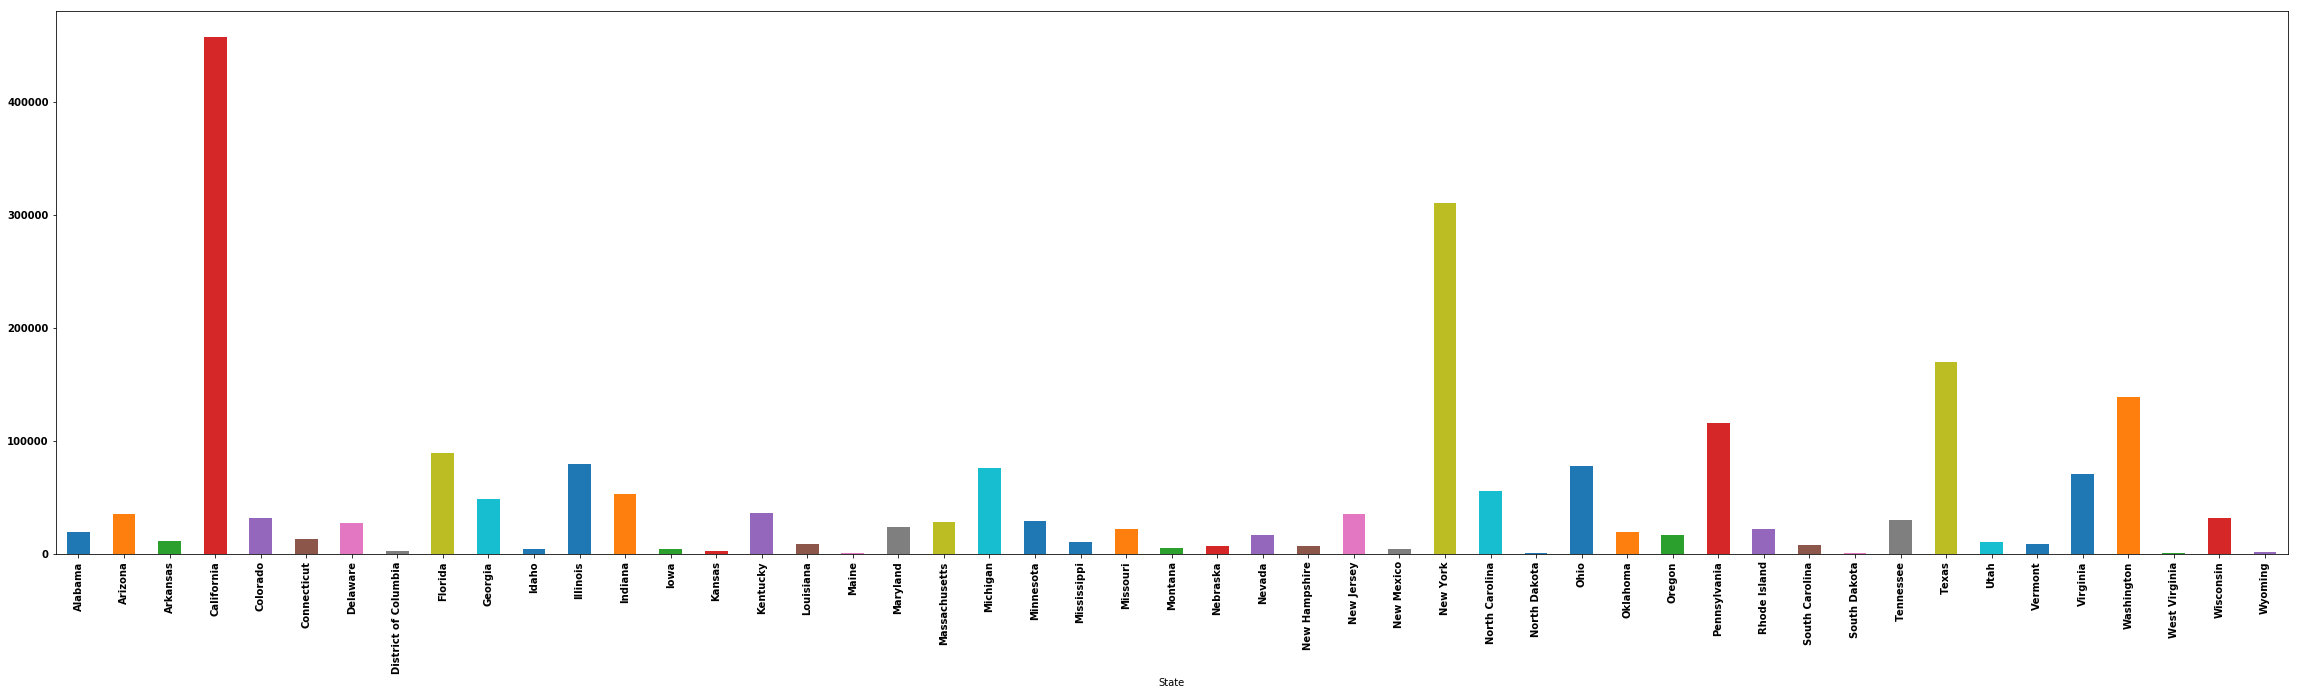

In [6]:
data.groupby(['State'])['Sales'].sum().plot(kind='bar', figsize=(40,10))

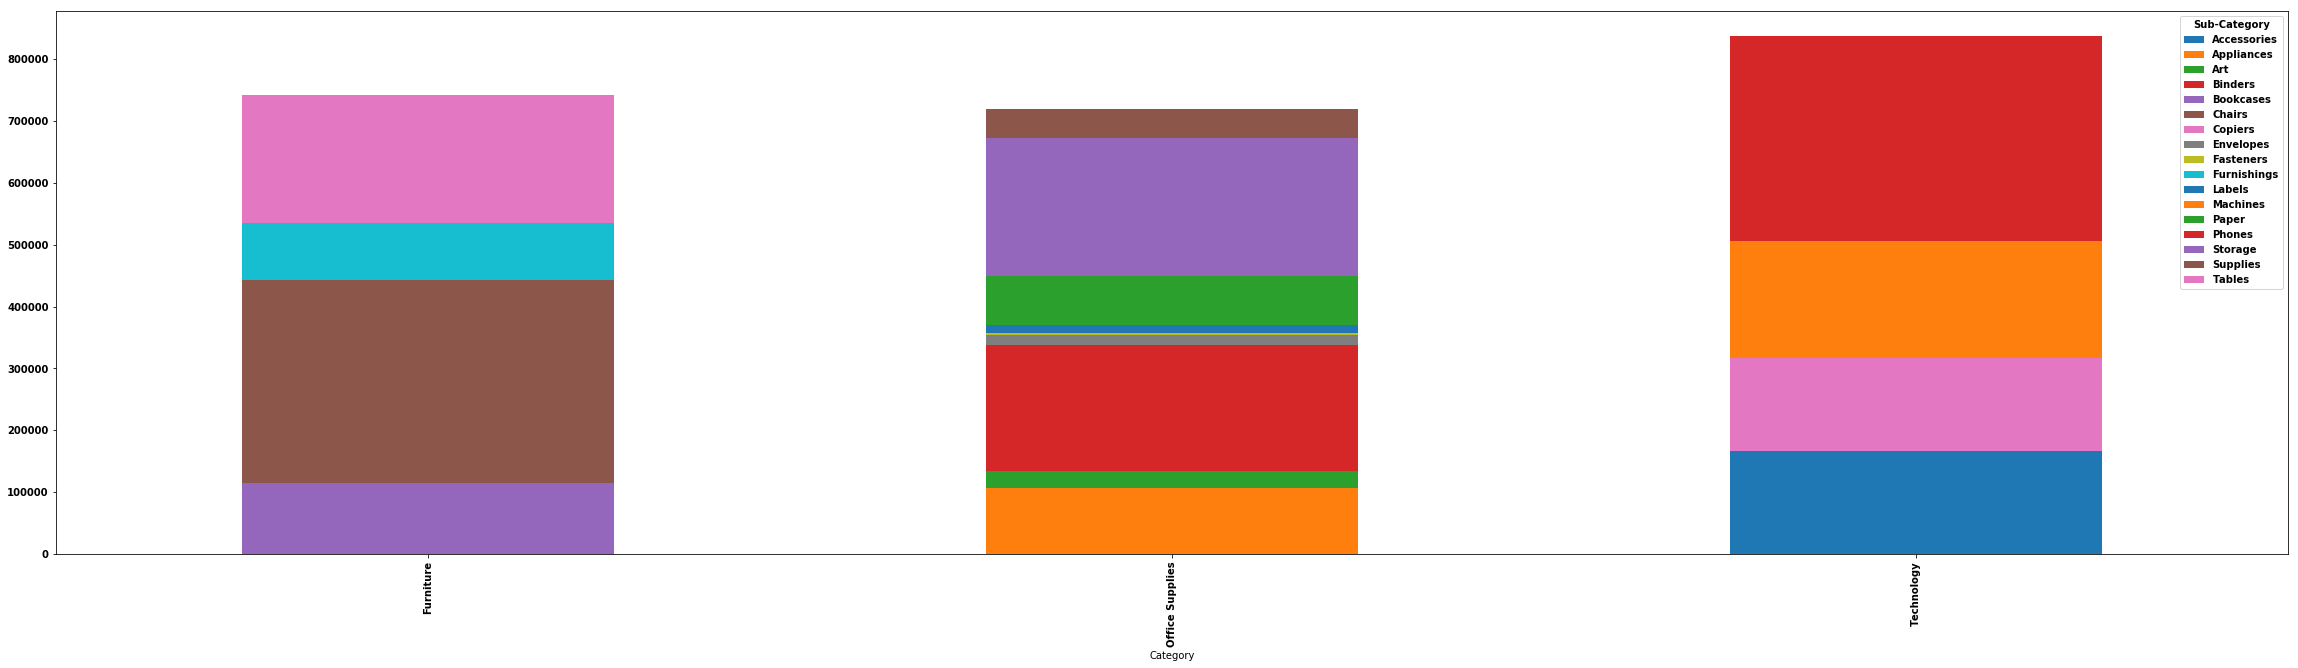

In [7]:
data.groupby(['Category','Sub-Category'])['Sales'].sum().unstack().plot(kind = 'bar', figsize=(40,10), stacked = True)

In [8]:
time_data = data[['Order Date','Sales']]
time_data = time_data.sort_values('Order Date')
time_data = time_data.groupby('Order Date')['Sales'].sum().reset_index()
time_data.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


In [9]:
time_data = time_data.set_index('Order Date')
# sampling data to month starting
tm_srs_dt = time_data['Sales'].resample('MS').mean()
tm_srs_dt.head()

Order Date
2014-01-01     647.131591
2014-02-01     225.994600
2014-03-01    2320.458708
2014-04-01    1178.972708
2014-05-01     844.581679
Freq: MS, Name: Sales, dtype: float64

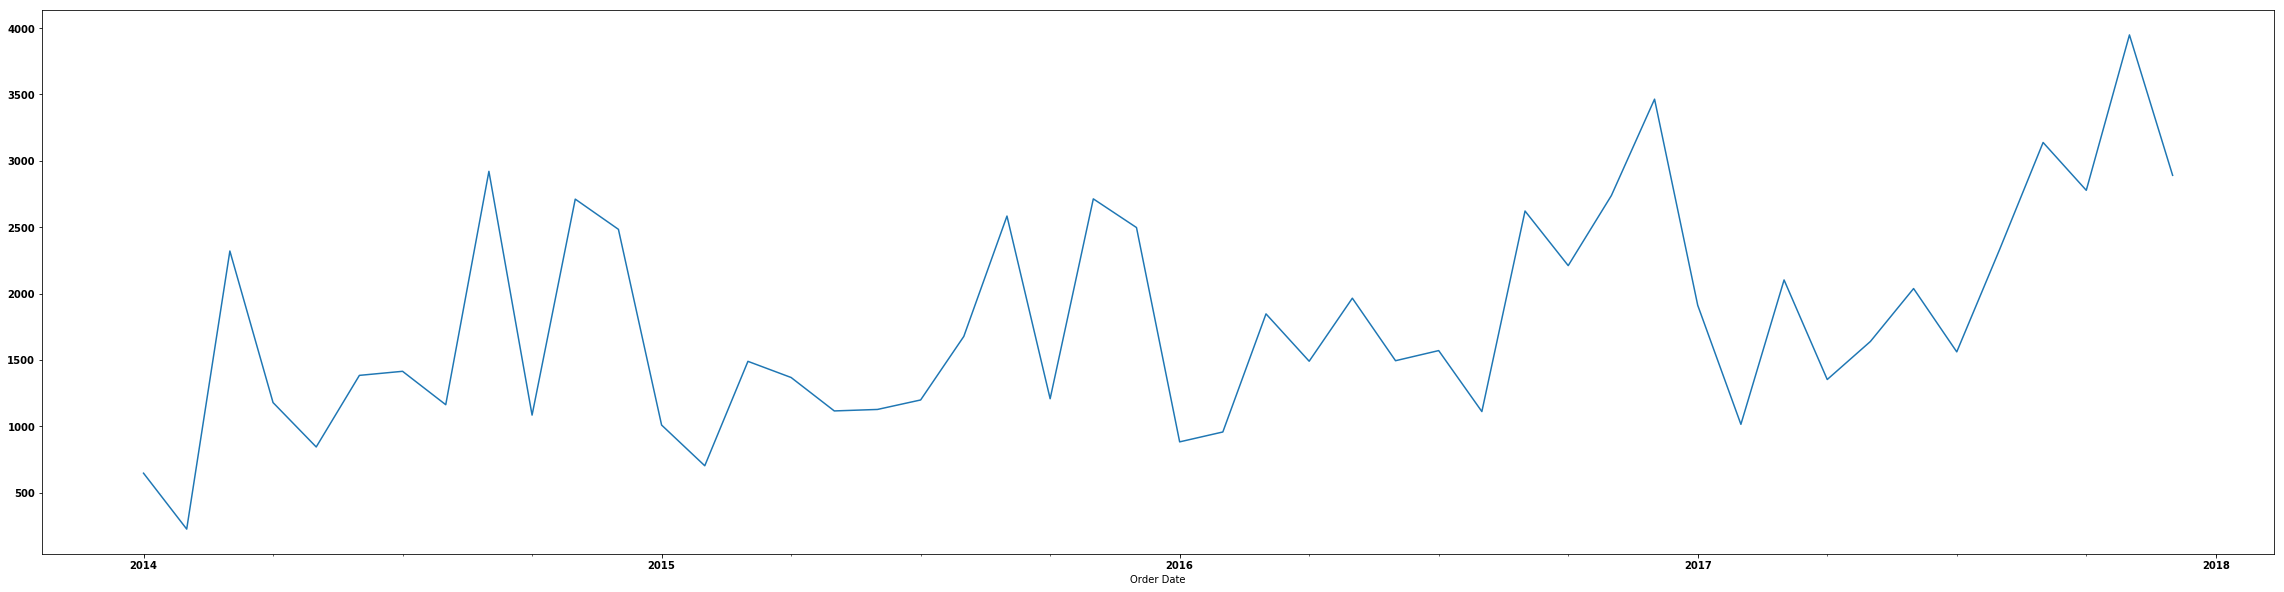

In [10]:
# Monthly sales
tm_srs_dt.plot(figsize = (40,10))

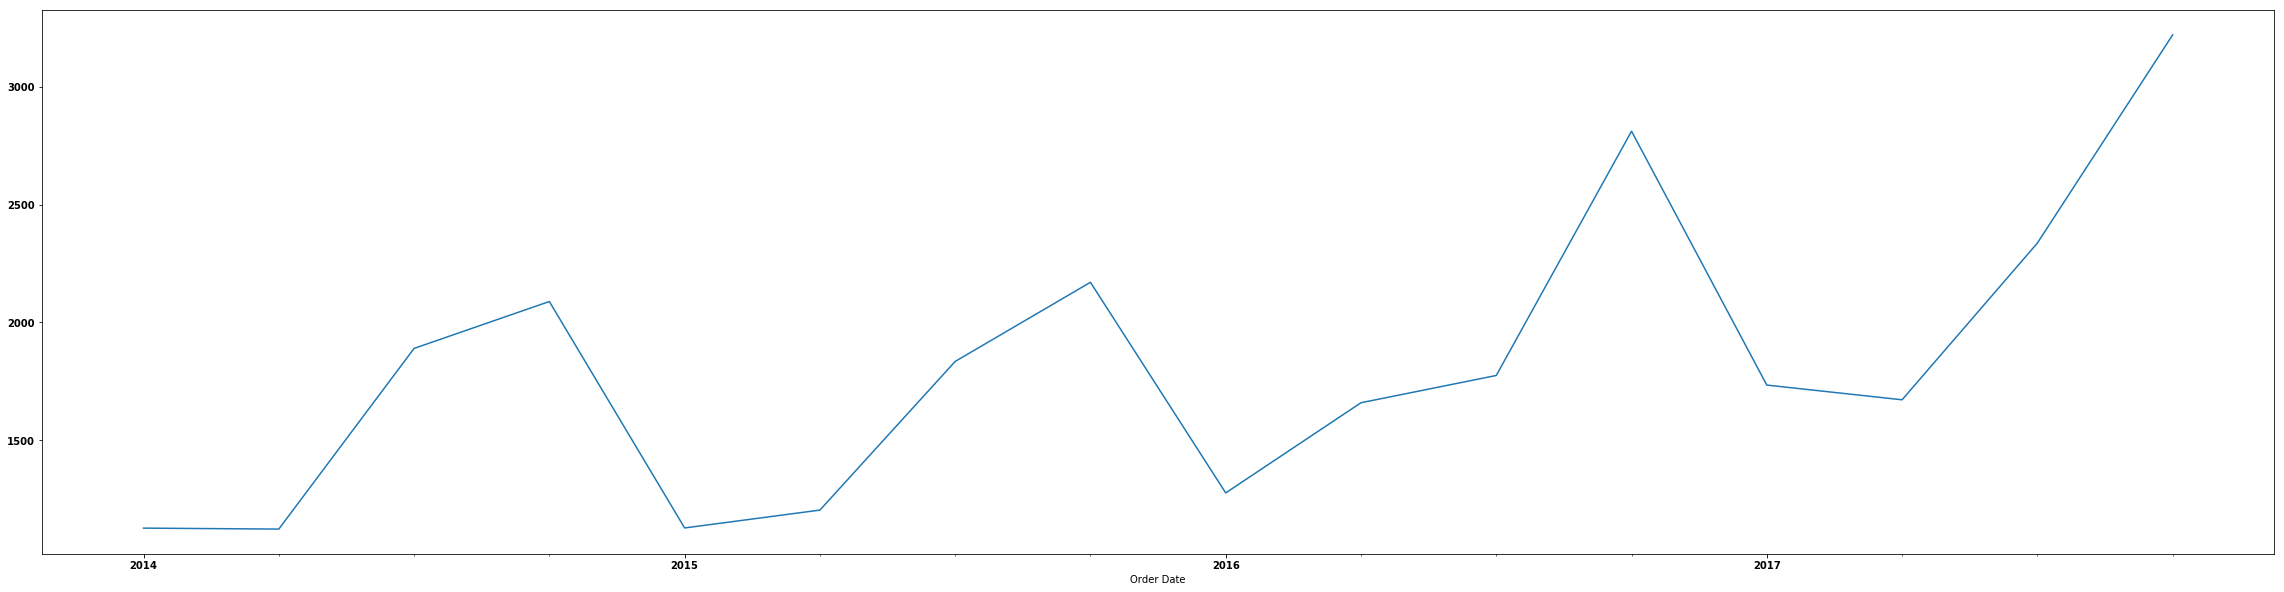

In [11]:
# Quarterly Sales
qtr = time_data['Sales'].resample('Q').mean()
qtr.plot(figsize=(40,10))
# evey year sales of Q1 < Q2 < Q3 < Q4

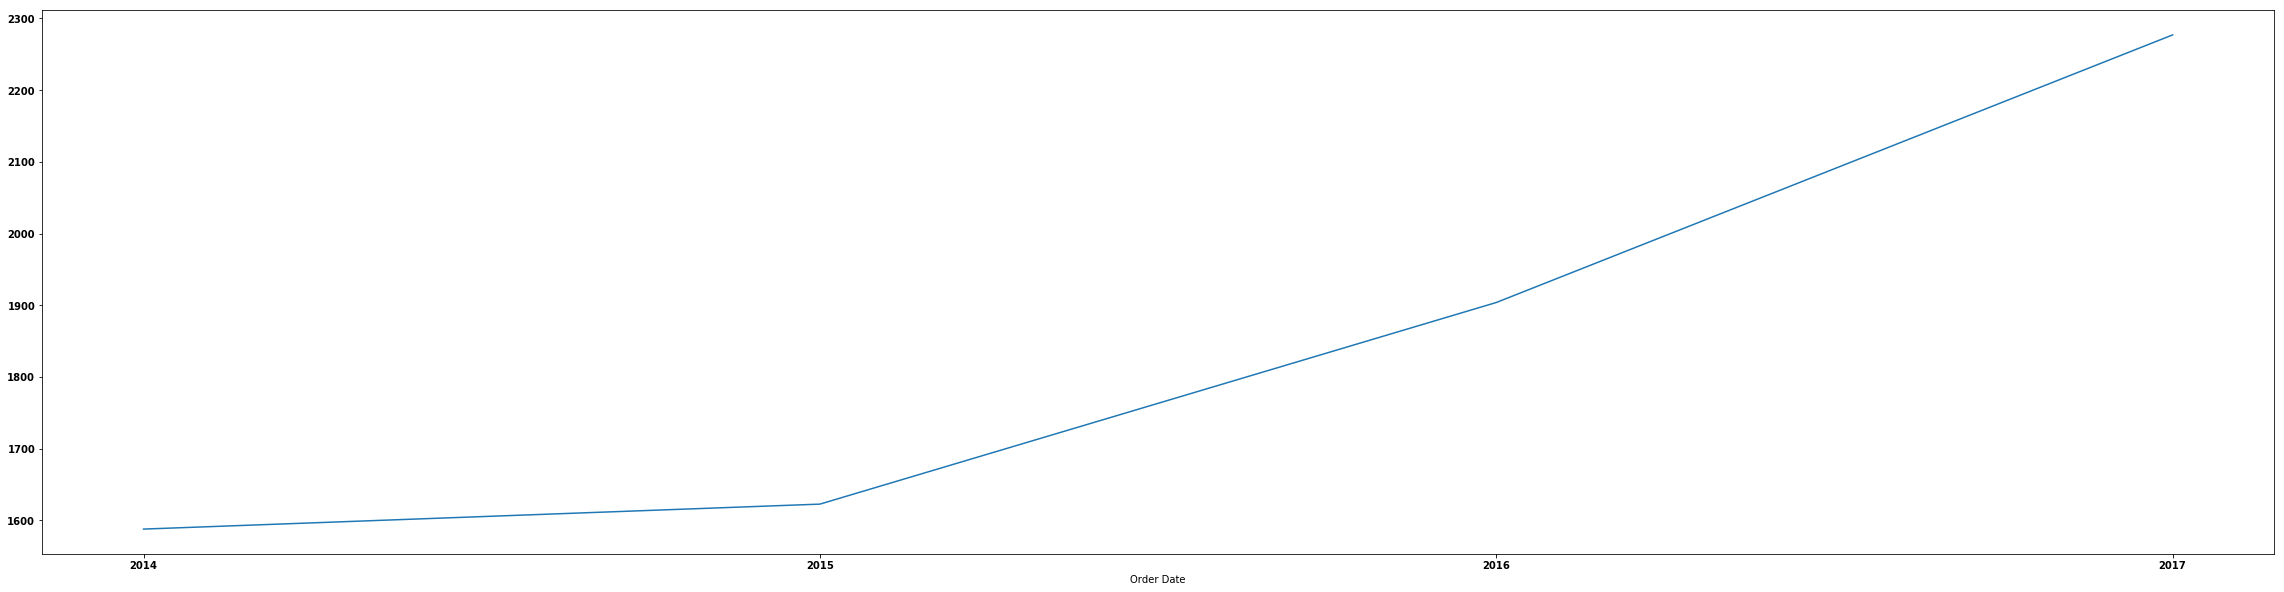

In [12]:
# Yearly sales
yr = time_data['Sales'].resample('A').mean()
yr.plot(figsize= (40,10))
# As the years progress the sales are increasing

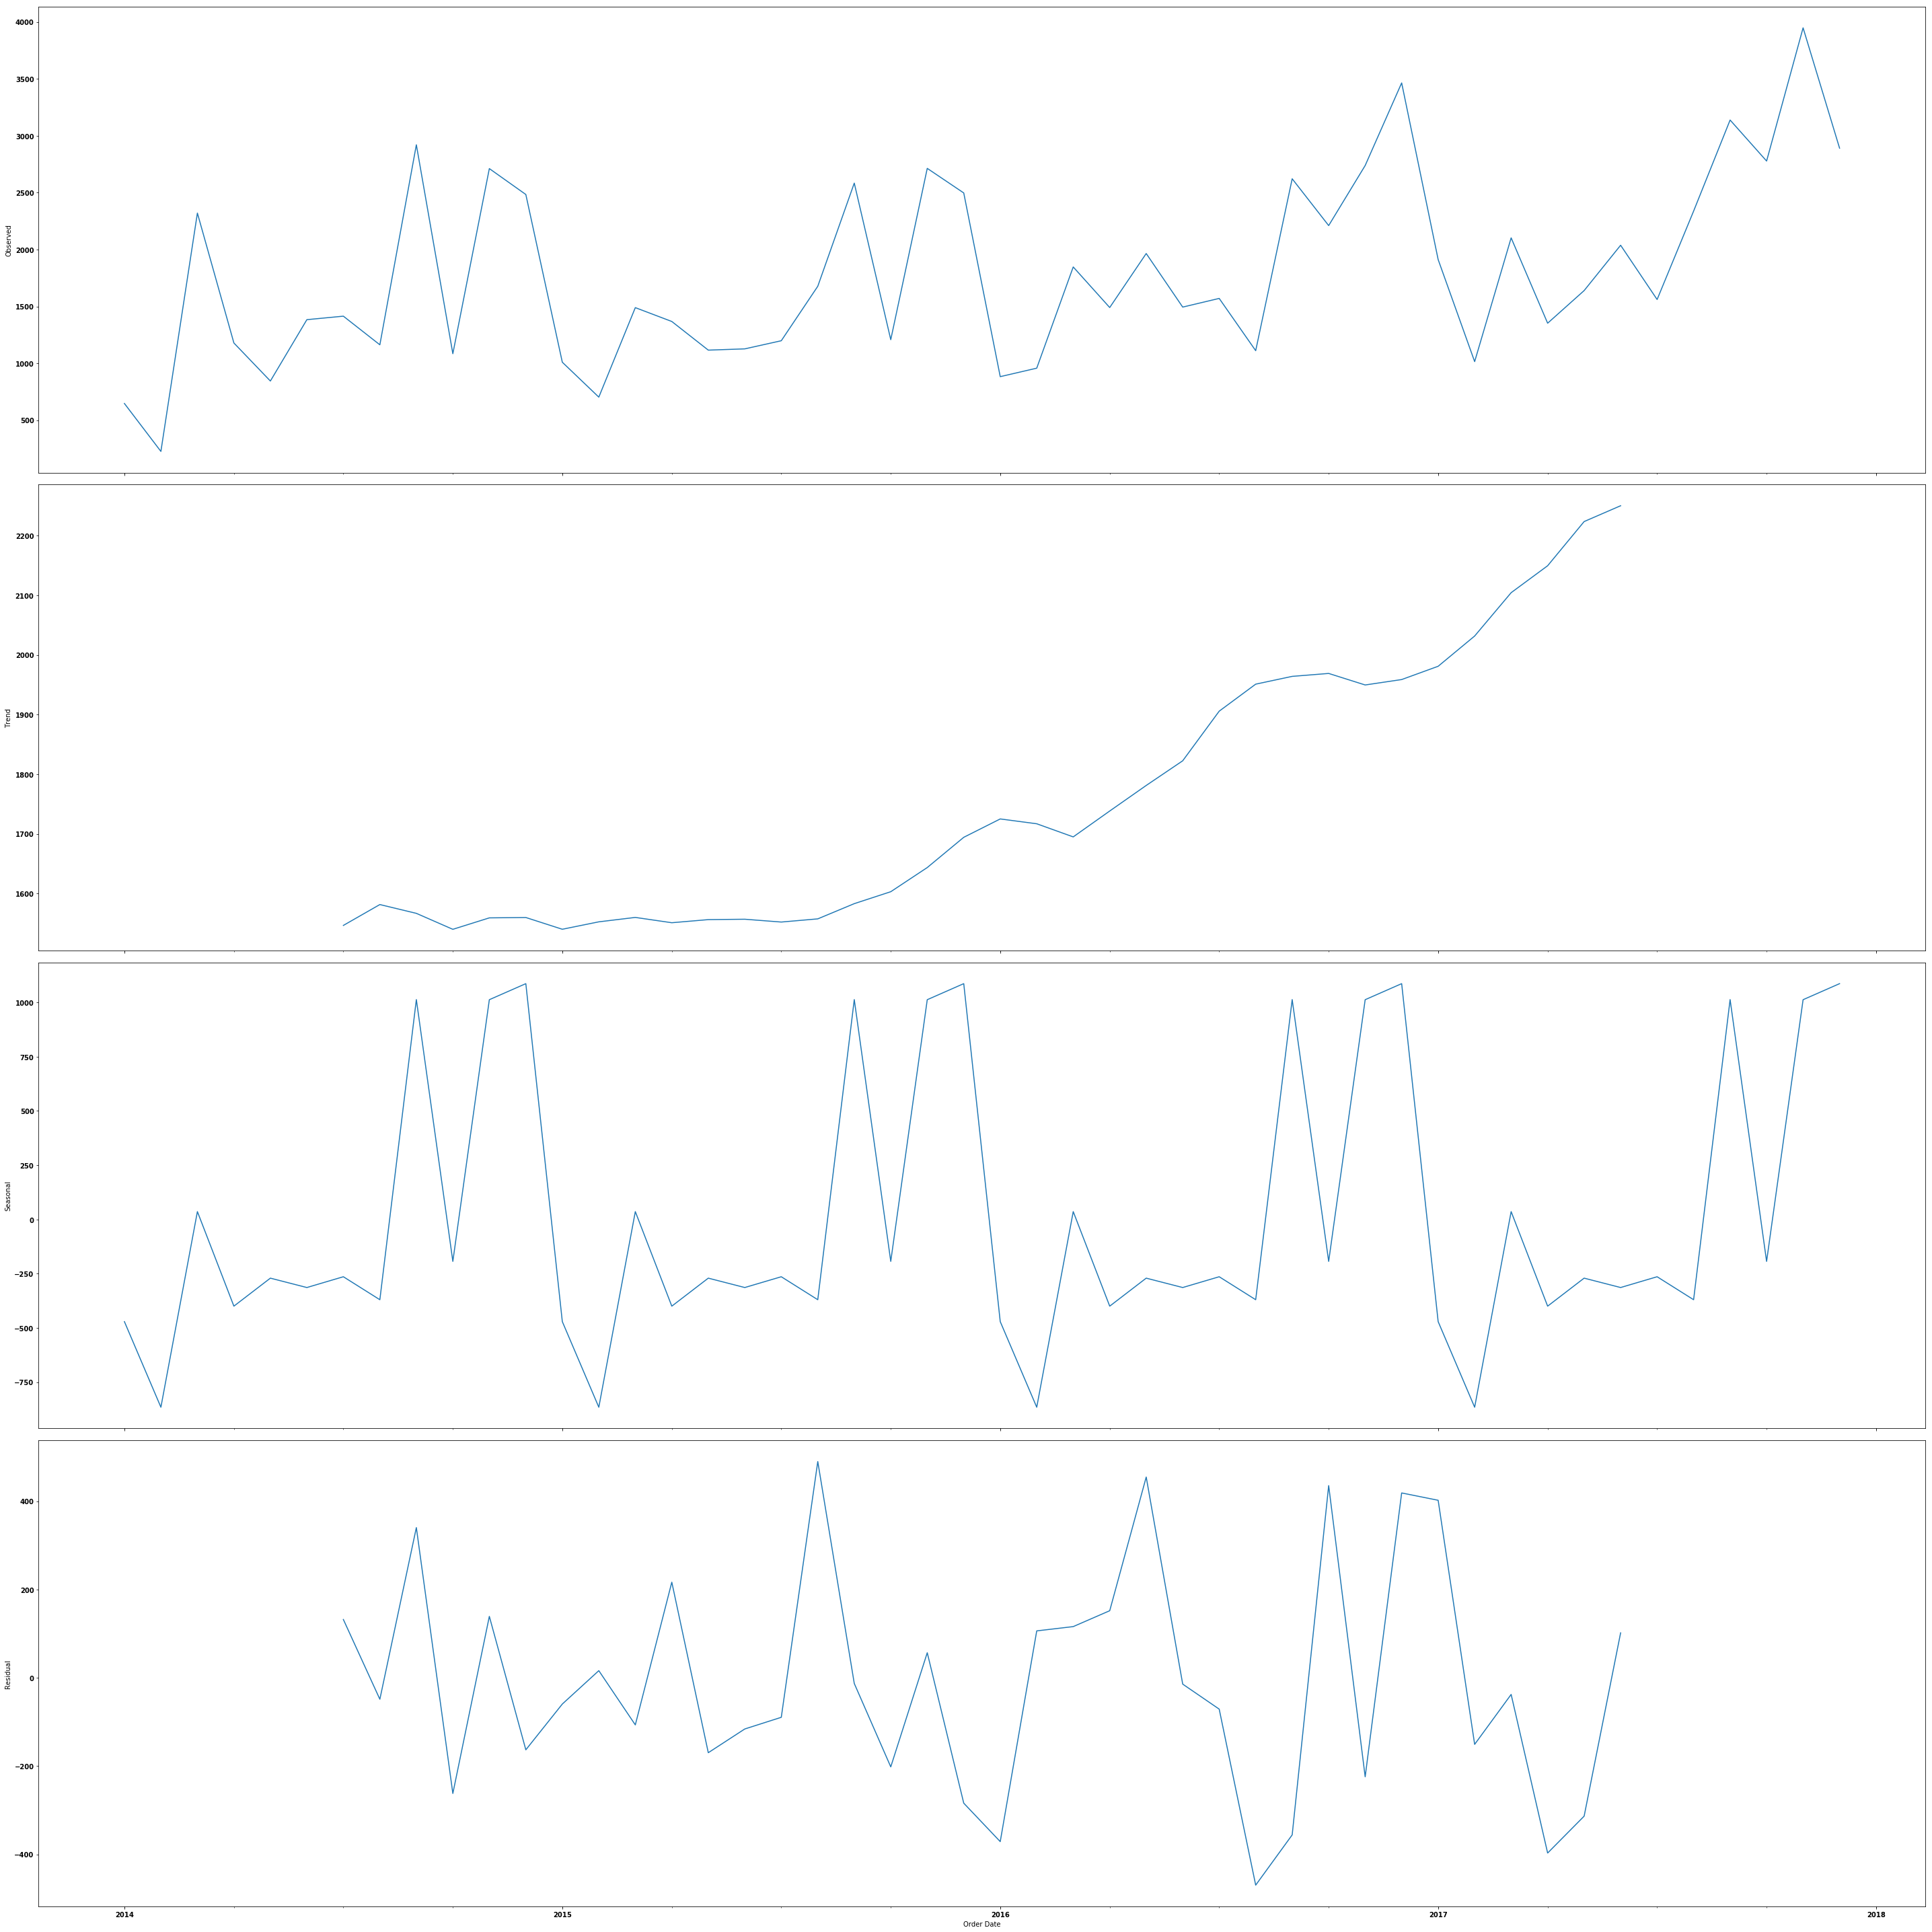

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40
decomposition = sm.tsa.seasonal_decompose(tm_srs_dt, model='additive')
decom_plot = decomposition.plot()

# There is an increasing treand
# an obvious seasonality 
# and sales are quit unstable

In [14]:
# checking for Stationary
# Augmented Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller
result = adfuller(tm_srs_dt)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
# as p value is less than 0.01 we reject the null i.e stationary 
# H0: non-stationary
# H1: stationary

ADF Statistic: -4.756843
p-value: 0.000066
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


In [15]:
p = i = q = range(0, 2)
coef = list(itertools.product(p, i, q))
ses_coef = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, i, q))]

for x in coef:
    for y in ses_coef:
        try:
            model = sm.tsa.statespace.SARIMAX(tm_srs_dt,order=x,seasonal_order=y,enforce_stationarity=False,enforce_invertibility=False)
            out = model.fit()
            print(str(x)+str(y)+ str(out.aic))
        except:
            continue
# (1, 1, 1) is selected because it has the least aic value

(0, 0, 0)(0, 0, 1, 12)1622.840791950166
(0, 0, 0)(1, 0, 0, 12)556.4030539681389
(0, 0, 0)(1, 0, 1, 12)536.1242565877509
(0, 0, 0)(1, 1, 0, 12)379.31311116746053
(0, 0, 1)(0, 0, 0, 12)800.954661500112
(0, 0, 1)(0, 0, 1, 12)3341.3133436344215
(0, 0, 1)(0, 1, 0, 12)528.8097917495911
(0, 0, 1)(1, 0, 0, 12)558.3100438922389
(0, 0, 1)(1, 0, 1, 12)520.422682671439
(0, 0, 1)(1, 1, 0, 12)378.64439838328906
(0, 1, 0)(0, 0, 1, 12)1200.9002529138695
(0, 1, 0)(1, 0, 0, 12)549.630700214917
(0, 1, 0)(1, 0, 1, 12)1456.3317048572005
(0, 1, 0)(1, 1, 0, 12)367.6372959140954
(0, 1, 1)(0, 0, 0, 12)726.8822219814775
(0, 1, 1)(0, 0, 1, 12)2663.0808104202542
(0, 1, 1)(0, 1, 0, 12)506.51020438908836
(0, 1, 1)(1, 0, 0, 12)539.5587096464615
(0, 1, 1)(1, 0, 1, 12)2851.198100577785
(0, 1, 1)(1, 1, 0, 12)355.76315927533886
(1, 0, 0)(0, 0, 0, 12)777.9055059640485
(1, 0, 0)(0, 0, 1, 12)1703.2545491798983
(1, 0, 0)(0, 1, 0, 12)543.6595443248249
(1, 0, 0)(1, 0, 0, 12)548.4301230014735
(1, 0, 0)(1, 0, 1, 12)542.80090609

In [16]:
final_model = sm.tsa.statespace.SARIMAX(tm_srs_dt,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
ans = final_model.fit()
ans.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -167.563
Date:                            Sun, 09 Sep 2018   AIC                            343.127
Time:                                    18:06:03   BIC                            350.611
Sample:                                01-01-2014   HQIC                           345.955
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0285      0.408     -0.070      0.944      -0.828       0.771
ma.L1         -1.0227      0.828     -1.235      0.217      -2.646       0.600
ar.S.L12      -0.4943      0.235     -2.105      0.035      -0.955      -0.034
sigma2      2.153e+05   2.47e+05      0.873      0.383   -2.68e+05    6.98e+05
===================================================================================
Ljung-Box (Q):                       33.15   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.04   Prob(JB):                         0.36
Heteroskedasticity (H):               1.55   Skew:                             0.24
Prob(H) (two-sided):                  0.58   Kurtosis:                         1.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

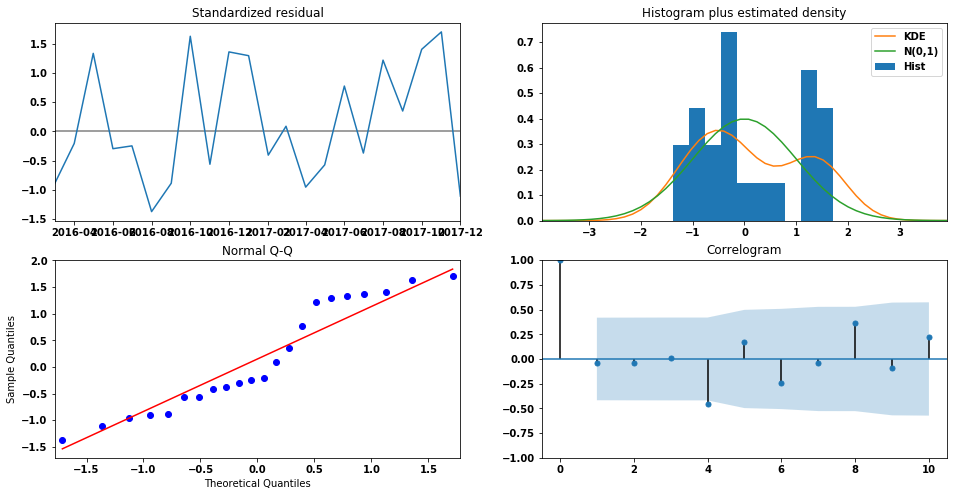

In [17]:
ans.plot_diagnostics(figsize=(16, 8))
plt.show()

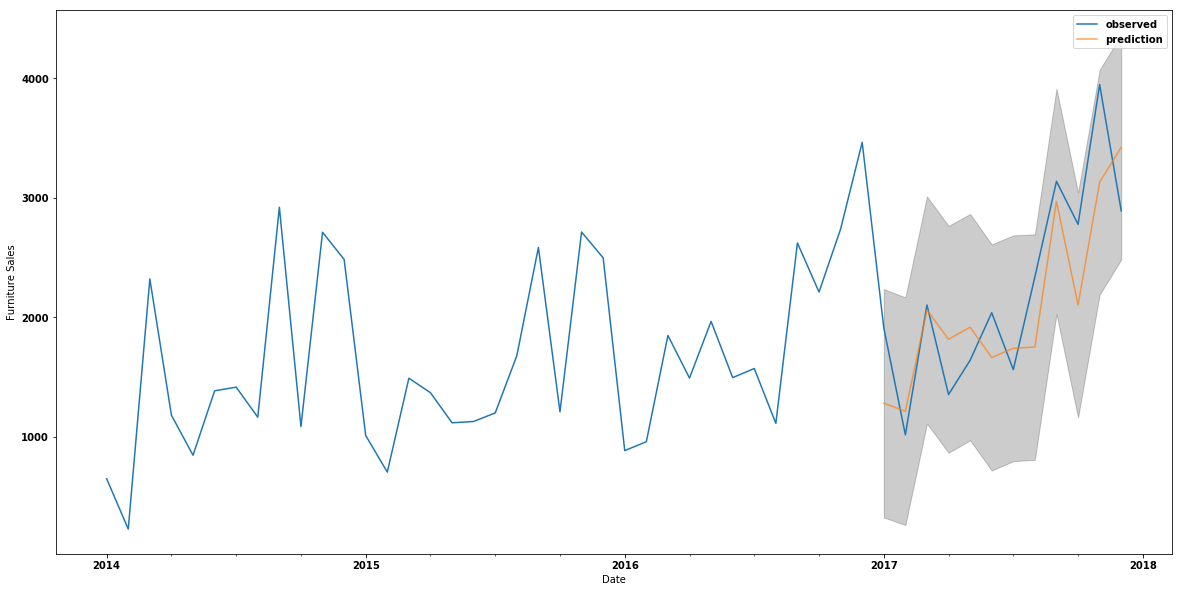

In [18]:
predict = out.get_prediction(start=pd.to_datetime('2017-01-01'))
pred_confidence_int = predict.conf_int()
plt.figure(figsize=(20, 10))
plot = tm_srs_dt.plot(label = 'observed')
predict.predicted_mean.plot(ax = plot, label = 'prediction', alpha=.7)
plot.fill_between(pred_confidence_int.index,
                pred_confidence_int.iloc[:, 0],
                pred_confidence_int.iloc[:, 1], color='k', alpha=.2)
plot.set_xlabel('Date')
plot.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


In [19]:
# to find the confidence intervel of our model we will use RMS error
y_pred = predict.predicted_mean
y = tm_srs_dt[pd.to_datetime('2017-01-01')]
mse = ((y_pred - y)**2).mean()
rms = np.sqrt(mse)
rms

704.8990623269699

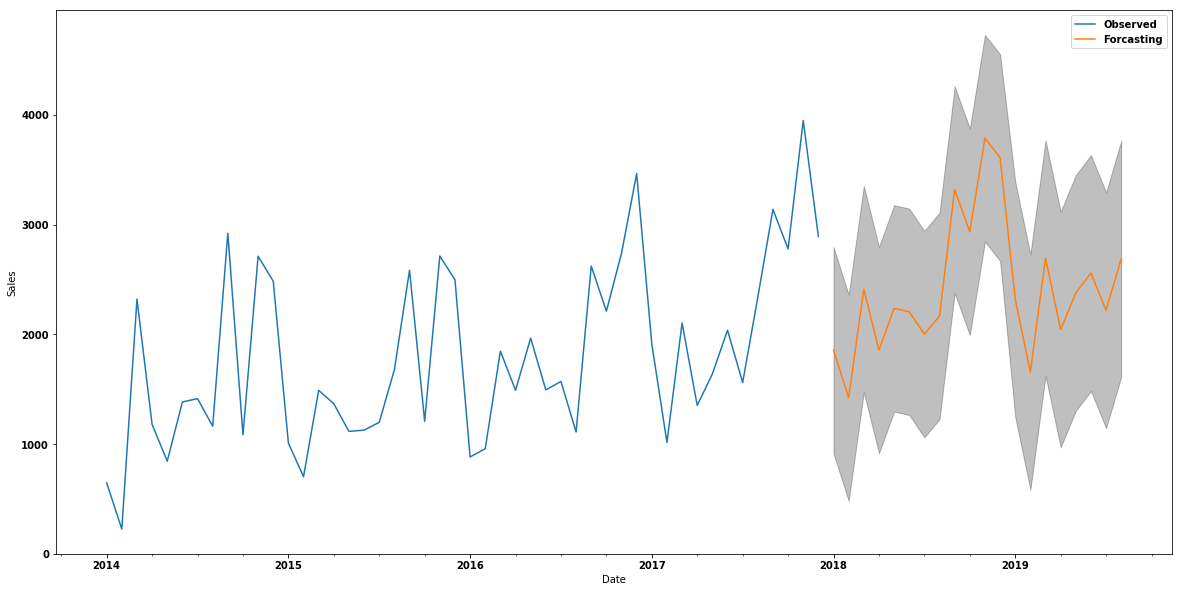

In [20]:
# forcasting

forcasting = ans.get_forecast(steps = 20)
fc_array = forcasting.conf_int()
#fc_array.head(5)
plt.figure(figsize=(20, 10))
plot_fc_20 = tm_srs_dt.plot(label = 'Observed')
forcasting.predicted_mean.plot(ax = plot_fc_20, label = "Forcasting")
plot_fc_20.fill_between(fc_array.index,
                fc_array.iloc[:, 0],
                fc_array.iloc[:, 1], color='k', alpha=.25)
plot_fc_20.set_xlabel('Date')
plot_fc_20.set_ylabel('Sales')
plt.legend()

In [21]:
data['Segment'].unique()

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [48]:
# let us forcast how the sales are for different segments 

consumer = data.loc[data['Segment'] == 'Consumer'][['Order Date','Sales']]
Corporate = data.loc[data['Segment'] == 'Corporate'][['Order Date','Sales']]
Home_Office = data.loc[data['Segment'] == 'Home Office'][['Order Date','Sales']]

print( "Number of consumers : {}".format(consumer.shape[0]))
print( "Number of Corporates : {}".format(Corporate.shape[0]))
print( "Number of Home Offices : {}".format(Home_Office.shape[0]))

Number of consumers : 5191
Number of Corporates : 3020
Number of Home Offices : 1783


In [49]:
consumer = consumer.sort_values('Order Date')
consumer = consumer.groupby('Order Date')['Sales'].sum()
consumer = consumer.resample('MS').mean()
Corporate = Corporate.sort_values('Order Date')
Corporate = Corporate.groupby('Order Date')['Sales'].sum()
Corporate = Corporate.resample('MS').mean()
Home_Office = Home_Office.sort_values('Order Date')
Home_Office = Home_Office.groupby('Order Date')['Sales'].sum()
Home_Office = Home_Office.resample('MS').mean()
#type(consumer)

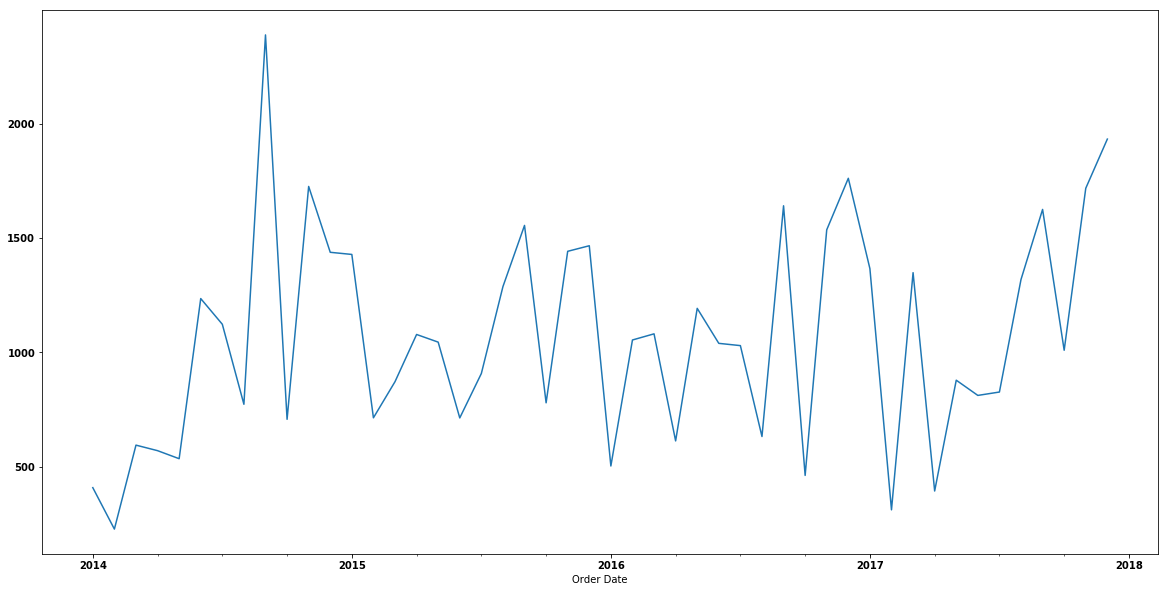

In [102]:
plt.figure(figsize=(20, 10))
consumer.plot(label = 'consumer')
plt.show()


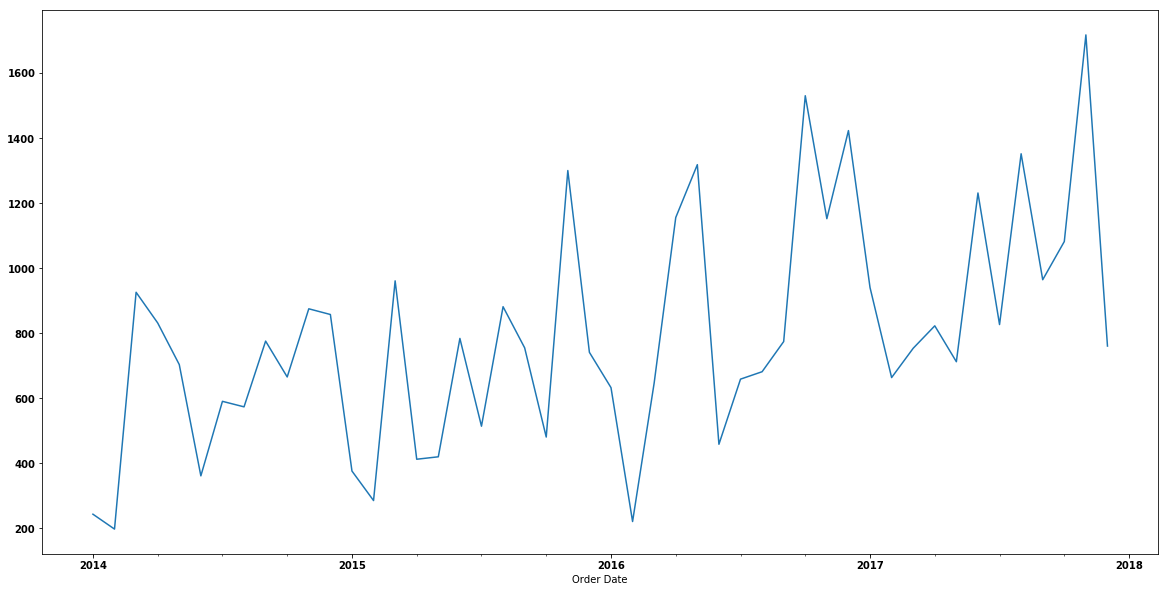

In [31]:
plt.figure(figsize=(20, 10))
Corporate.plot(label = 'Corporate')
plt.show()

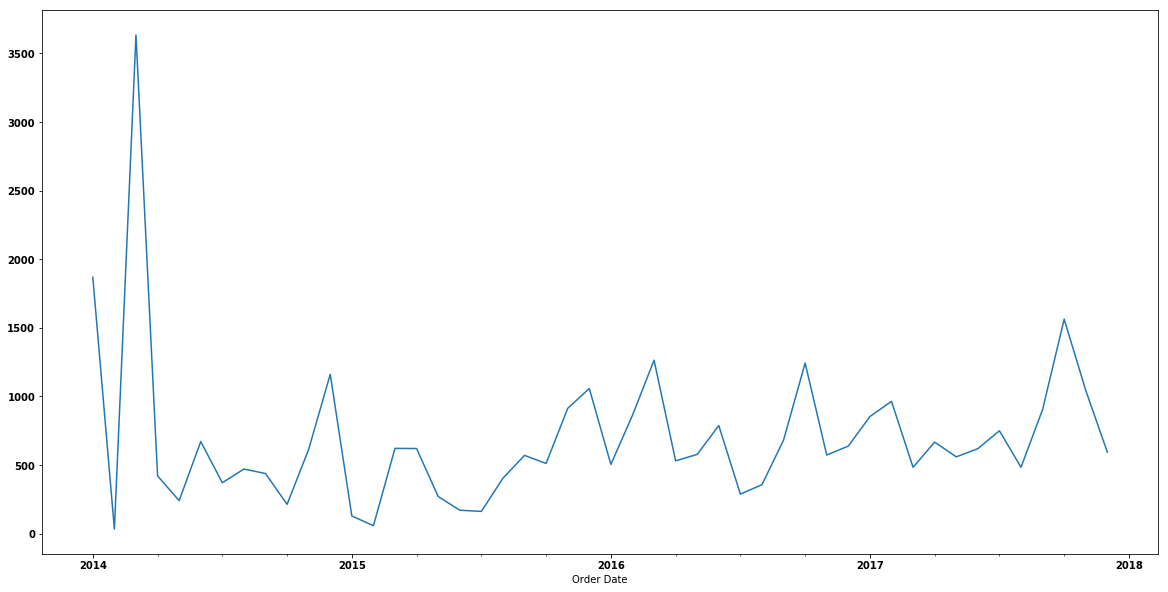

In [34]:
plt.figure(figsize=(20, 10))
Home_Office.plot(label = 'Home_Office')
plt.show()

In [55]:
from fbprophet import Prophet

def Prophet_fct(col):
    col_df = pd.DataFrame()
    col_df['ds'] = col.index
    col_df['y'] = col.values
    model = Prophet(interval_width = 0.95)
    return model.fit(col_df)

pro_consumer = Prophet_fct(consumer)
pro_Corporate = Prophet_fct(Corporate)
pro_Home_Office = Prophet_fct(Home_Office)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [78]:
pro_consumer_fct = pro_consumer.make_future_dataframe(periods=40, freq='MS')
pro_consumer_fct = pro_consumer.predict(pro_consumer_fct)
pro_consumer_fct.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
83,2020-12-01,1297.871821,1295.029112,2394.953995,1297.558213,1298.167339,567.965219,567.965219,567.965219,567.965219,567.965219,567.965219,0.0,0.0,0.0,1865.837040
84,2021-01-01,1301.588439,672.438290,1739.526672,1301.261924,1301.895328,-108.475707,-108.475707,-108.475707,-108.475707,-108.475707,-108.475707,0.0,0.0,0.0,1193.112733
85,2021-02-01,1305.305058,227.156929,1351.616354,1304.968867,1305.626079,-532.463210,-532.463210,-532.463210,-532.463210,-532.463210,-532.463210,0.0,0.0,0.0,772.841848
86,2021-03-01,1308.662005,676.200566,1735.516260,1308.310078,1308.999646,-86.475980,-86.475980,-86.475980,-86.475980,-86.475980,-86.475980,0.0,0.0,0.0,1222.186025
87,2021-04-01,1312.378624,341.864065,1397.378047,1312.009850,1312.730014,-414.290288,-414.290288,-414.290288,-414.290288,-414.290288,-414.290288,0.0,0.0,0.0,898.088335


In [79]:
pro_Corporate_fct = pro_Corporate.make_future_dataframe(periods=40, freq='MS')
pro_Corporate_fct = pro_Corporate.predict(pro_Corporate_fct)
pro_Corporate_fct.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,512.420288,-105.082104,758.422034,512.420288,512.420288,-176.988162,-176.988162,-176.988162,-176.988162,-176.988162,-176.988162,0.0,0.0,0.0,335.432126
1,2014-02-01,524.337301,-324.878549,536.811664,524.337301,524.337301,-397.739874,-397.739874,-397.739874,-397.739874,-397.739874,-397.739874,0.0,0.0,0.0,126.597427
2,2014-03-01,535.101054,186.414065,1027.434431,535.101054,535.101054,76.003132,76.003132,76.003132,76.003132,76.003132,76.003132,0.0,0.0,0.0,611.104186
3,2014-04-01,547.018067,97.789737,1012.200286,547.018067,547.018067,45.754104,45.754104,45.754104,45.754104,45.754104,45.754104,0.0,0.0,0.0,592.772171
4,2014-05-01,558.550660,120.065289,1014.942014,558.550660,558.550660,10.764999,10.764999,10.764999,10.764999,10.764999,10.764999,0.0,0.0,0.0,569.315659


In [80]:
pro_Home_Office_fct = pro_Home_Office.make_future_dataframe(periods=40, freq='MS')
pro_Home_Office_fct = pro_Home_Office.predict(pro_Home_Office_fct)
pro_Home_Office_fct.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,707.916811,-43.923763,1718.702641,707.916811,707.916811,152.629952,152.629952,152.629952,152.629952,152.629952,152.629952,0.0,0.0,0.0,860.546763
1,2014-02-01,707.028674,-426.875882,1362.646500,707.028674,707.028674,-222.194762,-222.194762,-222.194762,-222.194762,-222.194762,-222.194762,0.0,0.0,0.0,484.833912
2,2014-03-01,706.226485,589.573435,2420.593762,706.226485,706.226485,806.694237,806.694237,806.694237,806.694237,806.694237,806.694237,0.0,0.0,0.0,1512.920722
3,2014-04-01,705.338348,-344.651679,1490.138217,705.338348,705.338348,-132.942487,-132.942487,-132.942487,-132.942487,-132.942487,-132.942487,0.0,0.0,0.0,572.395861
4,2014-05-01,704.478860,-492.496393,1294.515224,704.478860,704.478860,-282.876370,-282.876370,-282.876370,-282.876370,-282.876370,-282.876370,0.0,0.0,0.0,421.602490


<Figure size 2880x720 with 0 Axes>

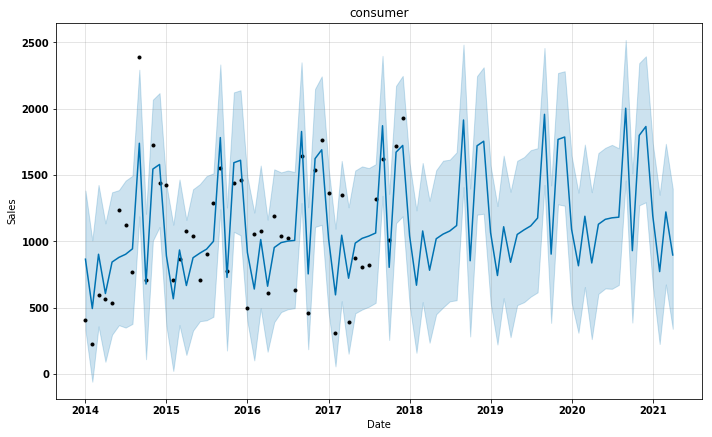

In [81]:
plt.figure(figsize=(40, 10))
pro_consumer.plot(pro_consumer_fct, xlabel = 'Date', ylabel = 'Sales')
plt.title('consumer');

<Figure size 2880x720 with 0 Axes>

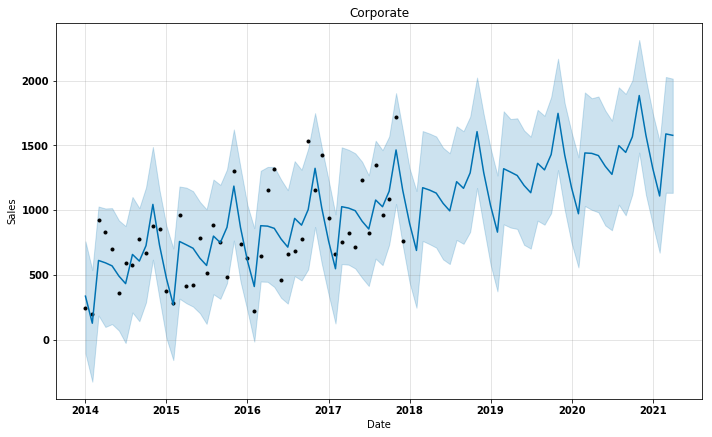

In [82]:
plt.figure(figsize=(40, 10))
pro_Corporate.plot(pro_Corporate_fct, xlabel = 'Date', ylabel = 'Sales')
plt.title('Corporate');

<Figure size 2880x720 with 0 Axes>

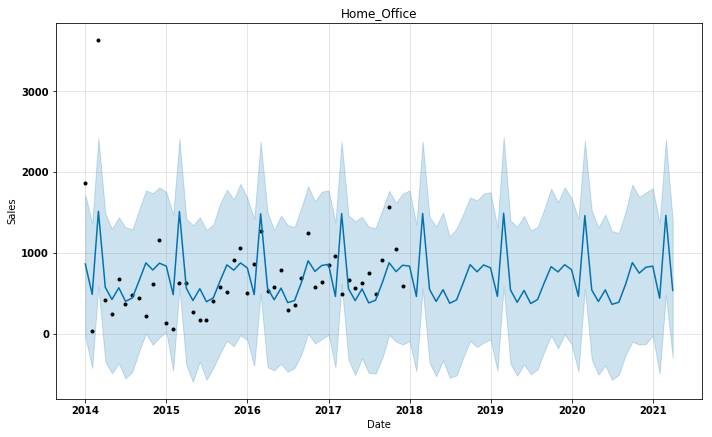

In [84]:
plt.figure(figsize=(40, 10))
pro_Home_Office.plot(pro_Home_Office_fct, xlabel = 'Date', ylabel = 'Sales')
plt.title('Home_Office');

In [92]:
#consumer Corporate Home_Office

consumer_new_names = ['consumer_%s' % column for column in pro_consumer_fct]
Corporate_new_names = ['Corporate_%s' % column for column in pro_Corporate_fct]
Home_Office_new_names = ['Home_Office_%s' % column for column in pro_Home_Office_fct]

new_consumer = pro_consumer_fct.copy()
new_consumer.columns = consumer_new_names
new_Corporate = pro_Corporate_fct.copy()
new_Corporate.columns = Corporate_new_names
new_Home_Office = pro_Home_Office_fct.copy()
new_Home_Office.columns = Home_Office_new_names

new = pd.merge(pd.merge(new_consumer, new_Corporate, how = 'inner', left_on= 'consumer_ds',
                       right_on = 'Corporate_ds'), new_Home_Office, how ='inner',
              left_on= 'consumer_ds', right_on = 'Home_Office_ds' )


,consumer_ds,consumer_trend,consumer_yhat_lower,consumer_yhat_upper,consumer_trend_lower,consumer_trend_upper,consumer_additive_terms,consumer_additive_terms_lower,consumer_additive_terms_upper,consumer_yearly,consumer_yearly_lower,consumer_yearly_upper,consumer_multiplicative_terms,consumer_multiplicative_terms_lower,consumer_multiplicative_terms_upper,consumer_yhat,Corporate_ds,Corporate_trend,Corporate_yhat_lower,Corporate_yhat_upper,Corporate_trend_lower,Corporate_trend_upper,Corporate_additive_terms,Corporate_additive_terms_lower,Corporate_additive_terms_upper,Corporate_yearly,Corporate_yearly_lower,Corporate_yearly_upper,Corporate_multiplicative_terms,Corporate_multiplicative_terms_lower,Corporate_multiplicative_terms_upper,Corporate_yhat,Home_Office_ds,Home_Office_trend,Home_Office_yhat_lower,Home_Office_yhat_upper,Home_Office_trend_lower,Home_Office_trend_upper,Home_Office_additive_terms,Home_Office_additive_terms_lower,Home_Office_additive_terms_upper,Home_Office_yearly,Home_Office_yearly_lower,Home_Office_yearly_upper,Home_Office_multiplicative_terms,Home_Office_multiplicative_terms_lower,Home_Office_multiplicative_terms_upper,Home_Office_yhat
0,2014-01-01,994.671428,331.033265,1383.202849,994.671428,994.671428,-128.258041,-128.258041,-128.258041,-128.258041,-128.258041,-128.258041,0.0,0.0,0.0,866.413388,2014-01-01,512.420288,-105.082104,758.422034,512.420288,512.420288,-176.988162,-176.988162,-176.988162,-176.988162,-176.988162,-176.988162,0.0,0.0,0.0,335.432126,2014-01-01,707.916811,-43.923763,1718.702641,707.916811,707.916811,152.629952,152.629952,152.629952,152.629952,152.629952,152.629952,0.0,0.0,0.0,860.546763
1,2014-02-01,998.418273,-56.629531,1008.395434,998.418273,998.418273,-503.659818,-503.659818,-503.659818,-503.659818,-503.659818,-503.659818,0.0,0.0,0.0,494.758455,2014-02-01,524.337301,-324.878549,536.811664,524.337301,524.337301,-397.739874,-397.739874,-397.739874,-397.739874,-397.739874,-397.739874,0.0,0.0,0.0,126.597427,2014-02-01,707.028674,-426.875882,1362.646500,707.028674,707.028674,-222.194762,-222.194762,-222.194762,-222.194762,-222.194762,-222.194762,0.0,0.0,0.0,484.833912
2,2014-03-01,1001.802521,360.573201,1425.615385,1001.802521,1001.802521,-98.238150,-98.238150,-98.238150,-98.238150,-98.238150,-98.238150,0.0,0.0,0.0,903.564371,2014-03-01,535.101054,186.414065,1027.434431,535.101054,535.101054,76.003132,76.003132,76.003132,76.003132,76.003132,76.003132,0.0,0.0,0.0,611.104186,2014-03-01,706.226485,589.573435,2420.593762,706.226485,706.226485,806.694237,806.694237,806.694237,806.694237,806.694237,806.694237,0.0,0.0,0.0,1512.920722
3,2014-04-01,1005.549366,93.732965,1136.088358,1005.549366,1005.549366,-397.915194,-397.915194,-397.915194,-397.915194,-397.915194,-397.915194,0.0,0.0,0.0,607.634172,2014-04-01,547.018067,97.789737,1012.200286,547.018067,547.018067,45.754104,45.754104,45.754104,45.754104,45.754104,45.754104,0.0,0.0,0.0,592.772171,2014-04-01,705.338348,-344.651679,1490.138217,705.338348,705.338348,-132.942487,-132.942487,-132.942487,-132.942487,-132.942487,-132.942487,0.0,0.0,0.0,572.395861
4,2014-05-01,1009.175345,297.442730,1370.346198,1009.175345,1009.175345,-164.303059,-164.303059,-164.303059,-164.303059,-164.303059,-164.303059,0.0,0.0,0.0,844.872286,2014-05-01,558.550660,120.065289,1014.942014,558.550660,558.550660,10.764999,10.764999,10.764999,10.764999,10.764999,10.764999,0.0,0.0,0.0,569.315659,2014-05-01,704.478860,-492.496393,1294.515224,704.478860,704.478860,-282.876370,-282.876370,-282.876370,-282.876370,-282.876370,-282.876370,0.0,0.0,0.0,421.602490


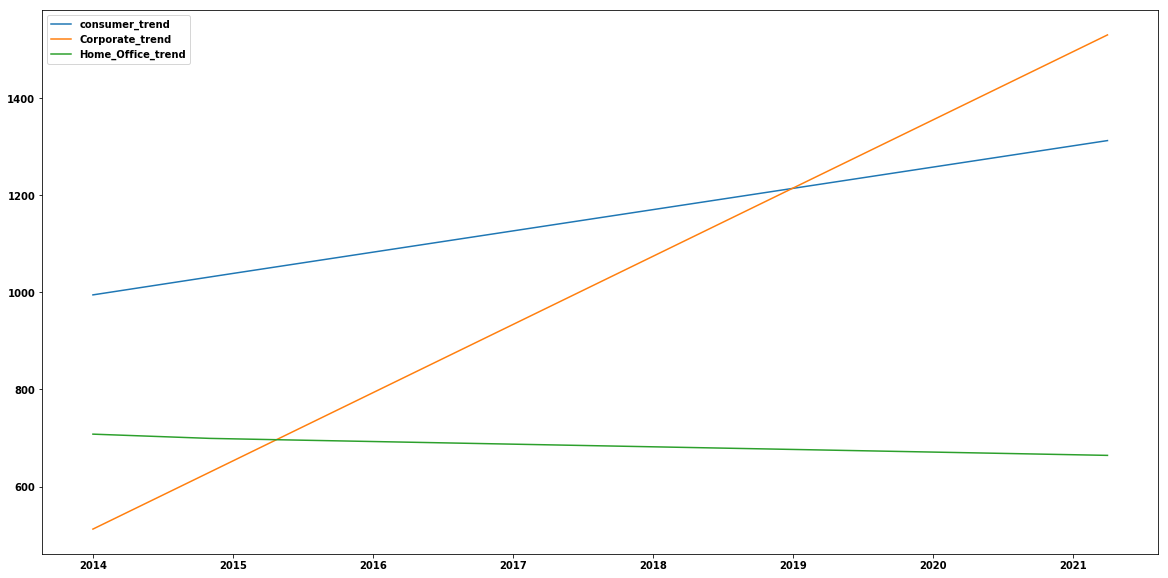

In [101]:
# ploting the trends of each segment

plt.figure(figsize = (20,10))
plt.plot(new['consumer_ds'], new['consumer_trend'])
plt.plot(new['consumer_ds'], new['Corporate_trend'])
plt.plot(new['consumer_ds'], new['Home_Office_trend'])
plt.legend()


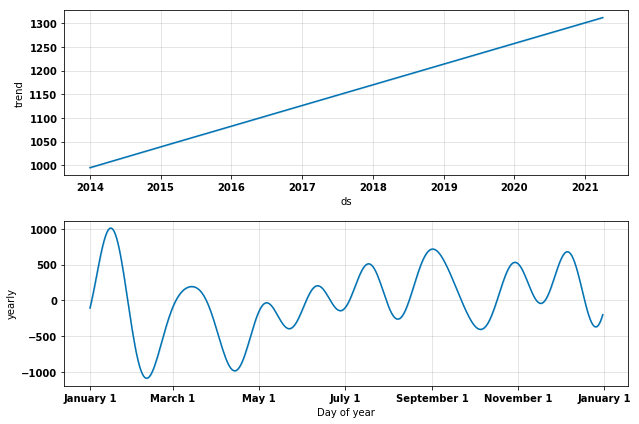

In [97]:
# extracting trends and pattens

pro_consumer.plot_components(pro_consumer_fct);

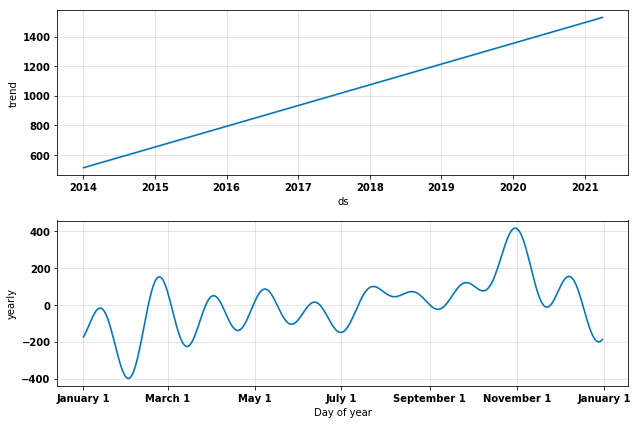

In [98]:
pro_Corporate.plot_components(pro_Corporate_fct);

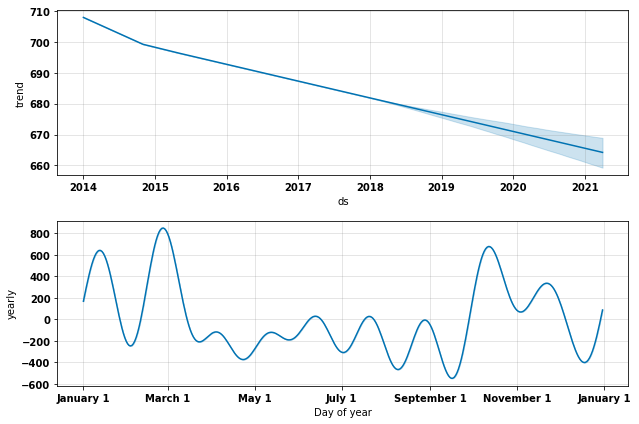

In [99]:
pro_Home_Office.plot_components(pro_Home_Office_fct);